# Take Home Assignment - 2021/01/22


Hi, thank you for your time for interviewing with us. This assignment is going to take around 1~2 hours to complete. 

### Dataset

The training and testing datasets are included in this folder. Please check.

The dataset we choose for this assignment is the boston housing dataset. Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository)
1. CRIM: per capita crime rate by town
2.	ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3.	INDUS: proportion of non-retail business acres per town
4.	CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5.	NOX: nitric oxides concentration (parts per 10 million)
6.	RM: average number of rooms per dwelling
7.	AGE: proportion of owner-occupied units built prior to 1940
8.	DIS: weighted distances to ﬁve Boston employment centers
9.	RAD: index of accessibility to radial highways
10.	TAX: full-value property-tax rate per 10,000 dollars
11.	PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population
14.	MEDV: Median value of owner-occupied homes in $1000s

We can see that the input attributes have a mixture of units.

### Tasks
1.	Please use any ML model (such as regression) to predict the housing value( MEDV ) for the test dataset. Please include all the procedures and code as well as the results.
2.	(Optional) If you have time left, please set up an endpoint api for predicting the result. So your endpoint should take the input data in test dataset( single row of data or a batch) and return the predictions. Please include your code and steps to use them.



# Table of Contents

1. Exploratory Data Analysis
2. Baseline Model
3. Cleaning the Data
4. Second Iteration Linear Model
5. Random Forest Regressor
6. Final Predicted Values
7. Conclusion

In [36]:
# import necessary libraries and functions
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from joblib import dump

In [2]:
# config

# setting random state for the models to set seed experiments replicable
random_state = 42

pd.options.display.float_format = "{:,.2f}".format

## Exploratory Data Analysis

Before running into models, must check if data is clean, and take a look at the stats of the data to start getting a feel and understanding of what the data contains.

In [3]:
train_data = pd.read_csv("HousingData_train.csv")
print("There are {} records in the train data.".format(train_data.shape[0]))

There are 467 records in the train data.


In [4]:
train_data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,447.00,448.00,448.00,449.00,467.00,467.00,448.00,467.00,467.00,467.00,467.00,467.00,449.00,467.00
mean,3.42,10.93,11.17,0.07,0.55,6.29,68.15,3.76,9.47,405.64,18.34,354.54,12.60,22.77
std,7.94,22.79,6.92,0.25,0.12,0.71,27.89,2.00,8.67,169.16,2.18,94.20,7.22,9.30
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,188.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.17,0.00,0.45,5.89,45.32,2.09,4.00,277.00,16.90,374.50,6.92,17.10
50%,0.25,0.00,9.90,0.00,0.53,6.22,76.50,3.27,5.00,329.00,18.70,391.23,11.10,21.50
75%,3.40,12.50,18.10,0.00,0.62,6.63,93.65,5.16,24.00,666.00,20.20,396.22,16.65,25.75
max,73.53,100.00,27.74,1.00,0.87,8.78,100.00,10.71,24.00,711.00,21.20,396.90,37.97,50.00


In [5]:
test_data = pd.read_csv("HousingData_test.csv")
print("There are {} records in the test data.".format(test_data.shape[0]))

There are 39 records in the test data.


In [6]:
test_data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,39.00,38.00,38.00,37.00,39.00,39.00,38.00,39.00,39.00,39.00,39.00,39.00,37.00
mean,5.80,14.53,10.08,0.08,0.57,6.19,72.84,4.18,10.51,439.28,19.83,382.26,14.09
std,15.03,29.74,5.71,0.28,0.12,0.54,29.27,3.10,9.18,159.67,1.44,34.74,6.26
min,0.02,0.00,1.69,0.00,0.39,5.39,8.40,1.39,1.00,187.00,15.90,232.60,3.11
25%,0.13,0.00,6.43,0.00,0.48,5.84,48.28,2.12,4.00,311.00,19.20,385.21,9.25
50%,0.29,0.00,8.56,0.00,0.54,6.11,86.25,2.72,5.00,384.00,20.20,393.29,13.59
75%,4.73,0.00,18.10,0.00,0.67,6.40,95.90,4.82,24.00,666.00,20.90,396.33,18.35
max,88.98,90.00,18.10,1.00,0.77,8.26,100.00,12.13,24.00,666.00,22.00,396.90,27.71


Taking a look at the stats above, we can compare the training and test sets. This is important as we want the data the model is being trained on to have similar statistics to the data the model is being tested on.

Taking a quick look the means and standard deviations sit close to each other with the two sets, with the largest discrepancy being the means of the ZN variable. With the statistics similar, this signals that we should hopefully get similar results when using the trained model on the unseen test data.



#### Handle Nulls
Nulls needs to be accounted for, whether we delete the rows or fill them.

First iteration will remove the nulls and see how the model performs, if poorly, we can impute the values to fill them if it makes sense in the context of the problem.

In [7]:
# check for nulls
train_data.isnull().sum()

CRIM       20
ZN         19
INDUS      19
CHAS       18
NOX         0
RM          0
AGE        19
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      18
MEDV        0
dtype: int64

In [8]:
# remove nulls
nn_train_data = train_data.dropna()
print("There are {} records left in the training data".format(nn_train_data.shape[0]))

There are 361 records left in the training data


If we remove all the rows with a null, we are left with about 77% of the original training data.

While not ideal, we still have a good majority of the records still in the training data.

In [9]:
test_data.isnull().sum()

CRIM       0
ZN         1
INDUS      1
CHAS       2
NOX        0
RM         0
AGE        1
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      2
dtype: int64

In [10]:
nn_test_data = test_data.dropna()
print("There are {} records left in the test data.".format(nn_test_data.shape[0]))

There are 33 records left in the test data.


We lose 6 records if we remove the ones with null values in the rows.

#### Check data types

Pre-liminary data types, going to explore and see which can be binned into categoricals

1. CRIM: per capita crime rate by town (float)
2.	ZN: proportion of residential land zoned for lots over 25,000 sq.ft. (float)
3.	INDUS: proportion of non-retail business acres per town (float)
4.	CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) (int)
5.	NOX: nitric oxides concentration (parts per 10 million) (float)
6.	RM: average number of rooms per dwelling (float)
7.	AGE: proportion of owner-occupied units built prior to 1940 (float)
8.	DIS: weighted distances to ﬁve Boston employment centers (float)
9.	RAD: index of accessibility to radial highways (int)
10.	TAX: full-value property-tax rate per 10,000 dollars (int)
11.	PTRATIO: pupil-teacher ratio by town (float)
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town (float)
13. LSTAT: % lower status of the population (float)
14.	MEDV: Median value of owner-occupied homes in $1000s (float, target variable)

In [11]:
train_data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

#### Distributions

To better understand the data, we can check how the distributions look. This will help us quickly identify if there are features with large amounts of outliers and help us understand the data from a visual point of view.

Keep in mind these are frequency distributions and not probability distributions. If we were looking at probablity distributions, we would be looking to see if the data has a Gaussian distribution to determine if the values are valid.

In [12]:
def plot_hist(ax, values, title, xlabel, ylabel):
    '''
    Plot histogram for feature to check distribution
    
    values (series/list): feature to check distribution of
    title (str): title of the plot
    xlabel (str): label for the x-axis
    ylabel (str): label for the y-axis
    '''
    ax.hist(values)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

C:\Users\jovin\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jovin\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


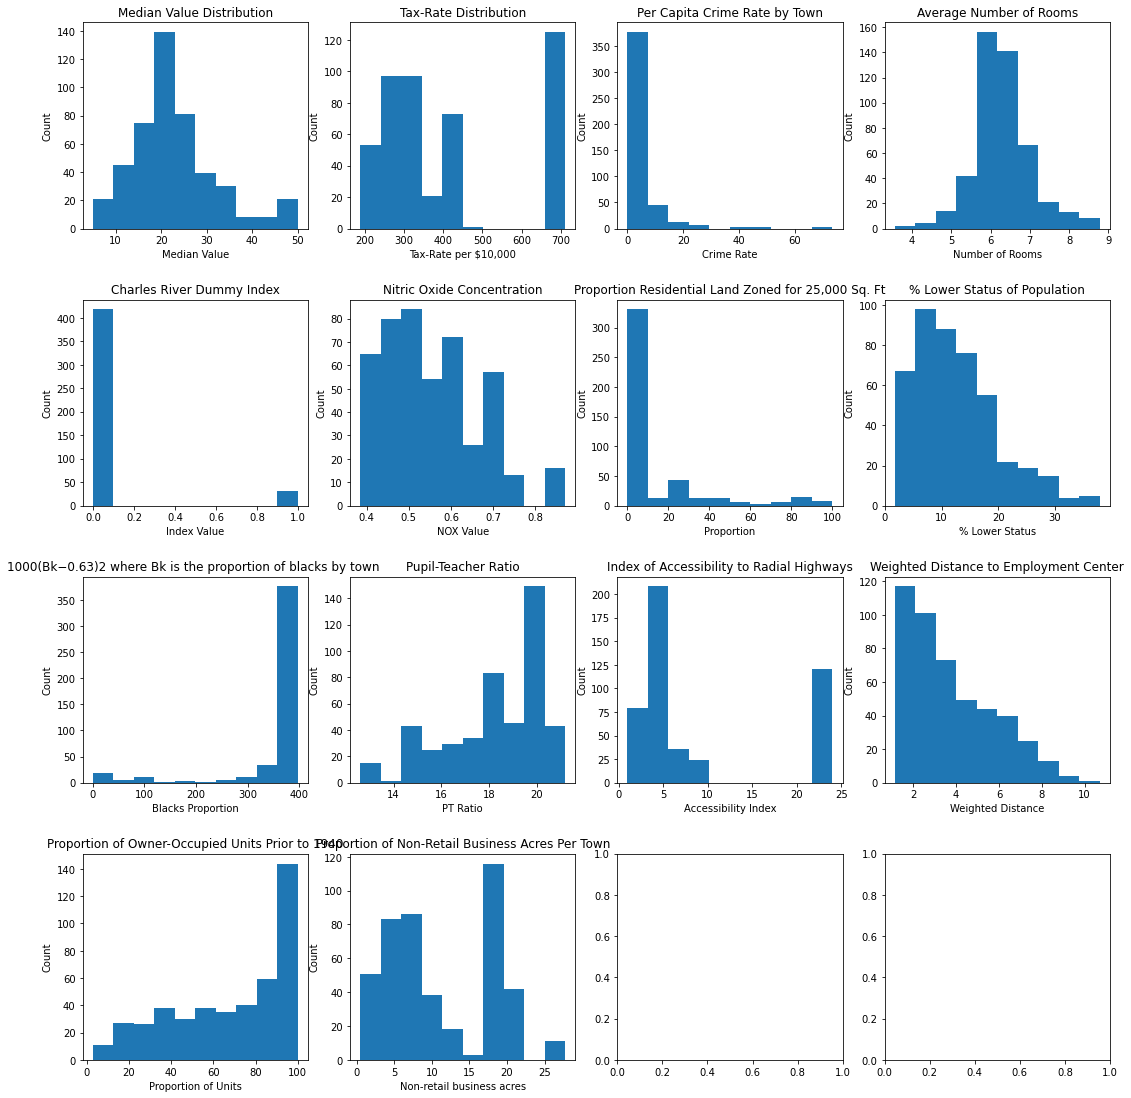

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))
fig.tight_layout(h_pad=5)

plot_hist(axs[0,0], train_data['MEDV'], 'Median Value Distribution', 'Median Value', 'Count')
plot_hist(axs[0,1], train_data['TAX'], 'Tax-Rate Distribution', 'Tax-Rate per $10,000', 'Count')
plot_hist(axs[0,2], train_data['CRIM'], 'Per Capita Crime Rate by Town', 'Crime Rate', 'Count')
plot_hist(axs[0,3], train_data['RM'], 'Average Number of Rooms', 'Number of Rooms', 'Count')
plot_hist(axs[1,0], train_data['CHAS'], 'Charles River Dummy Index', 'Index Value', 'Count')
plot_hist(axs[1,1], train_data['NOX'], 'Nitric Oxide Concentration', 'NOX Value', 'Count')
plot_hist(axs[1,2], train_data['ZN'], 'Proportion Residential Land Zoned for 25,000 Sq. Ft', 'Proportion', 'Count')
plot_hist(axs[1,3], train_data['LSTAT'], '% Lower Status of Population', '% Lower Status', 'Count')
plot_hist(axs[2,0], train_data['B'], '1000(Bk−0.63)2 where Bk is the proportion of blacks by town ', 'Blacks Proportion', 'Count')
plot_hist(axs[2,1], train_data['PTRATIO'], 'Pupil-Teacher Ratio', 'PT Ratio', 'Count')
plot_hist(axs[2,2], train_data['RAD'], 'Index of Accessibility to Radial Highways', 'Accessibility Index', 'Count')
plot_hist(axs[2,3], train_data['DIS'], 'Weighted Distance to Employment Center', 'Weighted Distance', 'Count')
plot_hist(axs[3,0], train_data['AGE'], 'Proportion of Owner-Occupied Units Prior to 1940', 'Proportion of Units', 'Count')
plot_hist(axs[3,1], train_data['INDUS'], 'Proportion of Non-Retail Business Acres Per Town', 'Non-retail business acres', 'Count')

From the charts above some interesting patterns can be identified:
1. There are several variables, like LSTAT, NOX, and RM, that slightly resemble the distribution of median housing prices. These variables are definitely worth looking into to see if the target variable is closer correlated with these variables than the others.
2. There is a large gap in the tax rate distribution between 500 and ~650. It may be worth looking into why there is a gap and see the relationship between the houses in that range with other variables to get a better idea of what the towns looked like and their demographics.  
3. The crime rate is mostly concentrated towards the lower end of the scale. This variable may not reveal much about median house pricing as the higher values can be considered outliers.
4. The same could be said about the ZN variable as well. The vast majority of houses are not zoned for larger than 25,000 sq. ft. as that is a very large amount of space for a house. More investigation needs to be done to see the relationship between this variable and the median price of a house.
5. The weighted distance between towns and employment centers steadily drops. This could signal that towns are generally built closer to employment centers and would be interesting to see the demographics of the towns that live further from employment centers. It could be the difference between people choosing to live further away, or people being forced to live further away. 
6. Distributions like TAX, INDUS, and RAD may be better represented at boolean or categorical values. i.e. Instead of having all the values for TAX just a boolean on whether or not TAX is higher than 500 per $10,000

#### Scatter plots Against the Target Variable

Using scatter plots, we can examine the relationship between the target variable and various independent variables, lke what kind of relationship they have, whether it be linear or logarithmic. This also gives us a way to get a birds eye view of the trends and let's us how closely related some sections of the data are to the median price.

In [14]:
def plot_scatter(ax, x_values, y_values, title, xlabel, ylabel):
    '''
    Plot histogram for feature to check distribution
    
    values (series/list): feature to check distribution of
    title (str): title of the plot
    xlabel (str): label for the x-axis
    ylabel (str): label for the y-axis
    '''
    ax.scatter(x_values, y_values)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

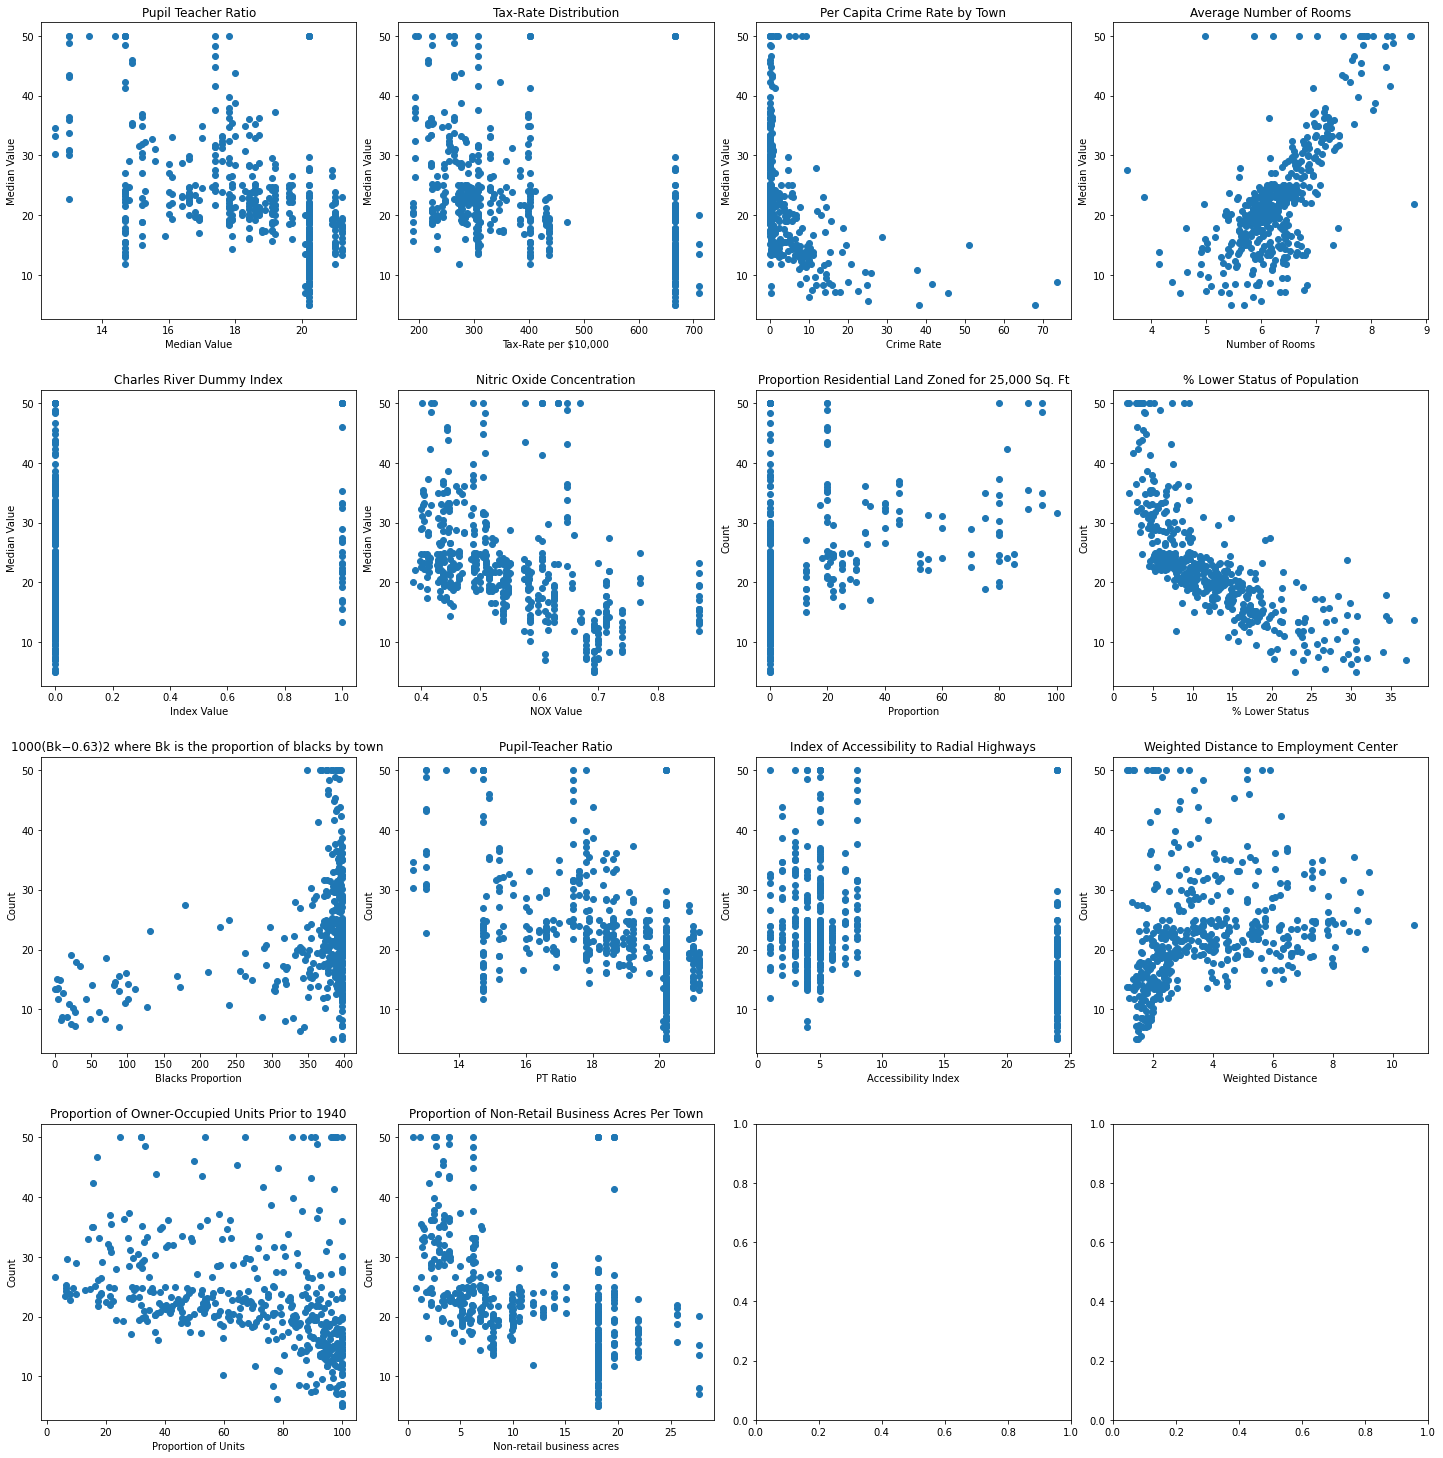

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(20,20))
fig.tight_layout(h_pad=5)

plot_scatter(axs[0,0], train_data['PTRATIO'], train_data['MEDV'], 'Pupil Teacher Ratio', 'Median Value', 'Median Value')
plot_scatter(axs[0,1], train_data['TAX'], train_data['MEDV'], 'Tax-Rate Distribution', 'Tax-Rate per $10,000', 'Median Value')
plot_scatter(axs[0,2], train_data['CRIM'], train_data['MEDV'], 'Per Capita Crime Rate by Town', 'Crime Rate', 'Median Value')
plot_scatter(axs[0,3], train_data['RM'], train_data['MEDV'], 'Average Number of Rooms', 'Number of Rooms', 'Median Value')
plot_scatter(axs[1,0], train_data['CHAS'], train_data['MEDV'], 'Charles River Dummy Index', 'Index Value', 'Median Value')
plot_scatter(axs[1,1], train_data['NOX'], train_data['MEDV'], 'Nitric Oxide Concentration', 'NOX Value', 'Median Value')
plot_scatter(axs[1,2], train_data['ZN'], train_data['MEDV'], 'Proportion Residential Land Zoned for 25,000 Sq. Ft', 'Proportion', 'Count')
plot_scatter(axs[1,3], train_data['LSTAT'], train_data['MEDV'], '% Lower Status of Population', '% Lower Status', 'Count')
plot_scatter(axs[2,0], train_data['B'], train_data['MEDV'], '1000(Bk−0.63)2 where Bk is the proportion of blacks by town ', 'Blacks Proportion', 'Count')
plot_scatter(axs[2,1], train_data['PTRATIO'], train_data['MEDV'], 'Pupil-Teacher Ratio', 'PT Ratio', 'Count')
plot_scatter(axs[2,2], train_data['RAD'], train_data['MEDV'], 'Index of Accessibility to Radial Highways', 'Accessibility Index', 'Count')
plot_scatter(axs[2,3], train_data['DIS'], train_data['MEDV'], 'Weighted Distance to Employment Center', 'Weighted Distance', 'Count')
plot_scatter(axs[3,0], train_data['AGE'], train_data['MEDV'], 'Proportion of Owner-Occupied Units Prior to 1940', 'Proportion of Units', 'Count')
plot_scatter(axs[3,1], train_data['INDUS'], train_data['MEDV'], 'Proportion of Non-Retail Business Acres Per Town', 'Non-retail business acres', 'Count')

Based on the scatter plots above the following can be inferred:
1. If we continue with the observations from above with LSTAT, RM, and NOX, we can see that while not exactly linear, these values are more linearly related than the other variables.
2. Looks like the higher tax rates are not related to higher value houses, which can say a lot about the historical context of the dataset.
3. Looks like the median price of a house generally gets higher as the distance gets further from the employment centers. It would be interesting to check this with historical rental rates, or the income levels of the people living in these areas.
4. Also as expected, as PTRatio increases, meaning more pupils per teacher, the graph is trending downwards with decreasing median price values. This trend can also be seen for Crime rate.
5. If you take a look at the AGE variable, you can see a downward trend in the housing prices as well.

Given the observations above, we can check to see if the coefficients of the regression model match up to the graphs, and have more context on the magnitude of values for the coefficients.

## Baseline Model

First let's train the model with the only modification to the training set being that we removed the rows with any null values.

The purpose of this baseline model is to give us an idea of performance with a simple model. There is no use in creating a complex model with heavy feature engineering if we don't have anything to compare it to.

In [16]:
# seperate the training data into an 85%/15% split
model_train, model_val = train_test_split(nn_train_data, train_size=0.85, random_state=random_state)

# training data without target variable
X = model_train.drop('MEDV', axis = 1)

# isolate target variable
y = model_train['MEDV']

# initializer linear regressor and fit to training data
lm = LinearRegression()
lm.fit(X, y)


LinearRegression()

In [17]:
print('Estimated intercept coefficient: {:.02f}'.format(lm.intercept_))

Estimated intercept coefficient: 35.57


We can pull out the intercept from the model to get an idea of what the base value would be without influence of the other variables.

In [18]:
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.06
1,ZN,0.04
2,INDUS,0.04
3,CHAS,3.00
4,NOX,-20.43
5,RM,4.18
6,AGE,-0.02
7,DIS,-1.65
8,RAD,0.27
9,TAX,-0.01


Looking above this gives us an idea of how each feature affects the price of a home in Boston.

We can use our observations above about the distributions of the data and the general trends of median price with each variable. Being able to confirm our assumptions from different angles allows us to have confidence that our model is performing as expected, and any discrepancies can be investigated further.

Some observations:
1. Looks like RM, NOX, and LSTAT all are behaving like expected following the positive trends for the former and the negative trends for the latter two. The magnitude of the values is something to take notice of though, was not expecting NOX to have such a negative effect on the median housing price.
2. Surprisingly the DIS variable has a negative coefficient even though the scatter plot above shows more of a positive relationship. This could be possible since the data is much more heavily concentrated towards the lower end of the spectrum for the values.
3. Looks like TAX, B, AGE, INDUS, ZN, and CRIM are a lot less influential in the median pricing for a house. These could be good candidates to remove for dimensionality reduction.

In [19]:
y_train_target = y
y_train_pred = lm.predict(X)

lm_train_mse = mean_squared_error(y_train_target, y_train_pred)
lm_train_rmse = math.sqrt(lm_train_mse)

print("MSE is {:.02f} for train set.".format(lm_train_mse))
print("RMSE is {:.02f} for train set.".format(lm_train_rmse))

# testing performance of baseline model
y_val_target = model_val['MEDV']
y_val_pred = lm.predict(model_val.drop('MEDV', axis=1))

lm_val_mse = mean_squared_error(y_val_target, y_val_pred)
lm_val_rmse = math.sqrt(lm_val_mse)

print("MSE is {:.02f} for val set.".format(lm_val_mse))
print("RMSE is {:.02f} for val set.".format(lm_val_rmse))


MSE is 19.38 for train set.
RMSE is 4.40 for train set.
MSE is 22.24 for val set.
RMSE is 4.72 for val set.


Looking at the metrics above, the model is predicting on average 4.71 points off of the true values of the housing prices in the validation set.

Let's see if we can do better.

## Cleaning the Data

#### Reduce Dimensionality by checking Collinearity

When developing a regression model, or any model for that matter, it is always good to check the collinearity of the features. When multiple features are highly correlated, this implies that as a group they are not adding new information and may be acting as noise, making it harder for the model to learn the data.

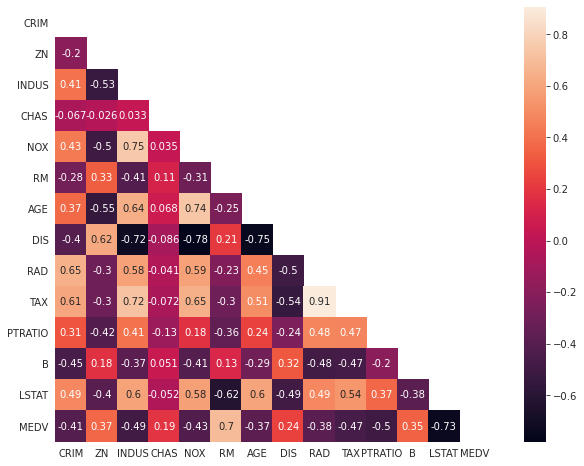

In [20]:
correlation = train_data.corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.heatmap(
        correlation,
        ax=ax,
        annot=True,
        mask=mask,
        square=True
    )

Based on the heatmap above: 
1. We can see that NOX has medium-high correlation with TAX, AGE, and INDUS.
2. RAD and TAX have very high correlation, one should be removed from the feature set.
3. RM and MEDV have medium-high correlation, while you cannot automatically assume causation, paired with the findings above, RM is looking like a significant feature for predicting pricing for a house.

#### Reduce Dimensionality by checking if the variable are statistically significant

Another way we can reduce dimensionality is by checking the p-vaues of each feature, and check which ones are statistically significant. If a p-values are lower than 0.05 the variable is deemed statistically significant and we can reject the null hypothesis.

In [21]:
reg = sm.OLS(y, X)

fit = reg.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              598.8
Date:                Thu, 04 Feb 2021   Prob (F-statistic):                   2.49e-202
Time:                        11:13:58   Log-Likelihood:                         -902.47
No. Observations:                 306   AIC:                                      1831.
Df Residuals:                     293   BIC:                                      1879.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0296      0.042     -0.699      0.485      -0.113       0.054
ZN             0.0462      0.017      2.659      0.008       0.012       0.080
INDUS          0.0054      0.079      0.068      0.946      -0.151       0.162
CHAS           3.2894      1.088      3.023      0.003       1.148       5.431
NOX           -4.9930      4.138     -1.207      0.229     -13.136       3.150
RM             6.2075      0.392     15.843      0.000       5.436       6.979
AGE           -0.0230      0.018     -1.275      0.203      -0.059       0.013
DIS           -1.1141      0.251     -4.432      0.000      -1.609      -0.619
RAD            0.1436      0.078      1.838      0.067      -0.010       0.297
TAX           -0.0110      0.005     -2.363      0.019      -0.020      -0.002
PTRATIO       -0.3895      0.138     -2.823      0.005      -0.661      -0.118
B              0.0157      0.003      4.802      0.000       0.009       0.022
LSTAT         -0.3159      0.061     -5.149      0.000      -0.437      -0.195
==============================================================================
Omnibus:                      107.738   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.148
Skew:                           1.328   Prob(JB):                    1.95e-133
Kurtosis:                       9.394   Cond. No.                     8.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking above we can see the following variables with higher p-values than we'd like:
1. CRIM
2. INDUS
3. NOX
4. AGE
5. RAD

For our next iteration of the regressor let's remove these variables and see how our model performs.

### Second Iteration Linear Model

Let's try fitting our regression model again and remove the following variables:
1. CRIM - p-value high
2. INDUS - p-value high
3. NOX - p-value high
4. AGE - p-value high
5. RAD - p-value high and highly correlated with TAX

In [22]:
remove_columns = ['CRIM', 'INDUS', 'NOX', 'AGE', 'RAD']
remaining_variables = [column for column in nn_train_data.columns if column not in remove_columns]
print(remaining_variables)

['ZN', 'CHAS', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


#### Evaluation

In [23]:
# seperate the training data into an 85%/15% split
model_train, model_val = train_test_split(nn_train_data, train_size=0.85, random_state=random_state)

# training data without target variable
X = model_train[remaining_variables]
X = X.drop('MEDV', axis = 1)

# isolate target variable
y = model_train['MEDV']

# initializer linear regressor and fit to training data
lm2 = LinearRegression()
lm2.fit(X, y)

# testing performance of baseline model
y_train_target = y
y_train_pred = lm2.predict(X)

lm2_train_mse = mean_squared_error(y_train_target, y_train_pred)
lm2_train_rmse = math.sqrt(lm2_train_mse)

print("MSE is {:.02f} for training set.".format(lm2_train_mse))
print("RMSE is {:.02f} for training set.".format(lm2_train_rmse))

# testing performance of baseline model
y_val_target = model_val['MEDV']
y_val_pred = lm2.predict(model_val[remaining_variables].drop('MEDV', axis=1))

lm2_val_mse = mean_squared_error(y_val_target, y_val_pred)
lm2_val_rmse = math.sqrt(lm2_val_mse)

print("MSE is {:.02f} for val set.".format(lm2_val_mse))
print("RMSE is {:.02f} for val set.".format(lm2_val_rmse))

MSE is 21.52 for training set.
RMSE is 4.64 for training set.
MSE is 23.85 for val set.
RMSE is 4.88 for val set.


In [24]:
reg = sm.OLS(y, np.asarray(X))

fit = reg.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              958.4
Date:                Thu, 04 Feb 2021   Prob (F-statistic):                   1.22e-207
Time:                        11:13:58   Log-Likelihood:                         -907.19
No. Observations:                 306   AIC:                                      1830.
Df Residuals:                     298   BIC:                                      1860.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0497      0.017      2.974      0.003       0.017       0.083
x2             3.4486      1.084      3.181      0.002       1.315       5.582
x3             5.6398      0.298     18.903      0.000       5.053       6.227
x4            -0.8525      0.212     -4.027      0.000      -1.269      -0.436
x5            -0.0069      0.002     -2.891      0.004      -0.012      -0.002
x6            -0.4075      0.136     -2.987      0.003      -0.676      -0.139
x7             0.0135      0.003      4.366      0.000       0.007       0.020
x8            -0.4004      0.051     -7.826      0.000      -0.501      -0.300
==============================================================================
Omnibus:                      102.735   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              473.911
Skew:                           1.331   Prob(JB):                    1.23e-103
Kurtosis:                       8.485   Cond. No.                     2.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While the RMSE did increase a tad bit with the second model (4.72 vs 4.88), I believe this model is more robust. This is due to the fact that all of the variables are statistically significant, meaning the values did not happen by chance and there is a pattern that the model is picking up on when calculating the regression values.

Another thing to take notice of is that the R-squared value from the first model and the second model did not change much (.964 vs .963), meaning much of the variance in the model was already captured, even after taking out those extra variables.

There are a few other ways we can evaluate the model other than just checking the metric. One way we will go over here is plotting the residuals vs the predicted values. The idea behind this method is to check if the values are randomly scattered across the horizontal axis. If they are, a linear model was appropriate for the problem, if not, perhaps a different type of relationship exists between the independent and dependent variables.

Text(0, 0.5, 'Predicted Values')

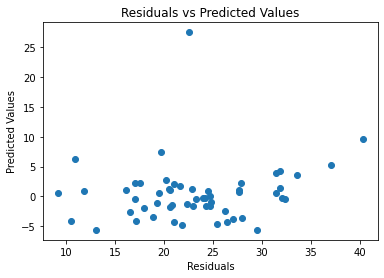

In [25]:
residuals = y_val_target - y_val_pred

plt.scatter(y_val_pred, residuals)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Residuals')
plt.ylabel('Predicted Values')

For the most part the scatter plot above displays that the predicted values and residuals hover around the horizontal axis (with the exception of the single outlier). This allows us to safely assume that there is a linear relationship between the independent and dependent variables.

### Random Forest Regressor

To throw another model into the mix, we can also use a random forest as a regressor. Random forest algorithm is an ensemble algorithm that takes the result of many decision trees and averages the results.

Also with testing the random forest regressor, I will also use grid search and k-fold cross validation. 

Grid Search allows us to test different sets of hyper-parameters and return the best performing ones. The parameters we will be experimenting with here are max depth and n estimators. Max depth determines the max depth of the decision trees when the model is running, and n estimators is the number of trees that will be used to average the result.

K-fold cross-validation is a way to test your model is robust. What it does partition the data into different sets or "folds". It then reserves one of the folds and trains the model with the rest of the data, returning a metric score. The process continues by holding out different sets of data and training on the rest in rotation. Doing this allows you to see if the data is evenly distributed and is performing generally the same with different subsets of the original data.

In [26]:
def random_forest_model(X, y, params):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid=params,
        cv=5, 
        scoring='neg_root_mean_squared_error', 
        verbose=1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    print("The best params are:")
    print("Max Depth: {}".format(best_params['max_depth']))
    print("N Estimators: {}".format(best_params['n_estimators']))
    
    random_forest = RandomForestRegressor(max_depth=best_params["max_depth"], 
                                          n_estimators=best_params["n_estimators"], 
                                          random_state=False)
    # Perform K-Fold CV
    scores = cross_val_score(random_forest, X, y, cv=10, scoring='neg_root_mean_squared_error')

    return scores, random_forest

In [27]:
# fit the model using grid search and cross-validation, return best model and scores
params = {
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
            'random_state': [random_state]
        }

scores, rf_model = random_forest_model(X, y, params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.4min finished


The best params are:
Max Depth: 6
N Estimators: 100


In [28]:
print("The average RMSE after cross-validation on the random forest: {:.02f}".format(np.mean(scores)))

The average RMSE after cross-validation on the random forest: -3.55


#### Fit and Evaluation Metric for Random Forest

In [29]:
rf_model.fit(X, y)

# testing train set with model
y_train_target = y
y_train_pred = rf_model.predict(X)

rf_train_mse = mean_squared_error(y_train_target, y_train_pred)
rf_train_rmse = math.sqrt(rf_train_mse)

print("MSE is {:.02f} for Train Set.".format(rf_train_mse))
print("RMSE is {:.02f} for Train Set.".format(rf_train_rmse))

# testing performance of baseline model
y_val_target = model_val['MEDV']
y_val_pred = rf_model.predict(model_val[remaining_variables].drop('MEDV', axis=1))

rf_val_mse = mean_squared_error(y_val_target, y_val_pred)
rf_val_rmse = math.sqrt(rf_val_mse)

print("MSE is {:.02f} for Validtion Set.".format(rf_val_mse))
print("RMSE is {:.02f} for Validation Set.".format(rf_val_rmse))

MSE is 3.80 for Train Set.
RMSE is 1.95 for Train Set.
MSE is 11.16 for Validtion Set.
RMSE is 3.34 for Validation Set.


From the results above, we can see that a random forest regressor performs a bit better than the linear model regressor. While this is great, and we should all strive for better metrics, we also have to take into account the processing power required to run these models. It is not obvious now, but if the dataset was much larger computational requirements for training and using random forests for predictions can grow much larger than running a simpler linear regression model.

Also another thing to take notice of is that the RF model is performing significantly better on the training set. This is an indicator of overfitting, meaning the data may not generalize as well to unseen data.

### Final Predicted Values

Now that we have our models, we can predict the values of the test data set.



In [30]:
def pre_processing_pipeline(data):
    '''
    pre-processing pipeline for incoming data
    '''
    # removing these columns as they were deemed statistically insiginificant by linear regression analysis
    remove_columns = ['CRIM', 'INDUS', 'NOX', 'AGE', 'RAD']
    
    # drop the rows with null values from the dataset
    data = data.dropna()
    
    for column in remove_columns:
        if column in data.columns:
            data = data.drop(column, axis=1)
    
    return data

First we must take the pre-processing steps we took above and bundle them up into a function. This can be used later when we deploy the model as well.

In [31]:
processed_test_data = pre_processing_pipeline(test_data)

processed_test_data.head()

,ZN,CHAS,RM,DIS,TAX,PTRATIO,B,LSTAT
0,0.00,0.00,5.63,1.82,666,20.20,396.90,22.88
4,0.00,0.00,6.38,1.39,666,20.20,396.90,23.69
5,0.00,0.00,6.22,1.39,666,20.20,393.74,21.78
6,0.00,0.00,6.97,1.42,666,20.20,396.90,17.21
7,0.00,0.00,6.54,1.52,666,20.20,396.90,21.08


Then we can make predictions on the data and add them to the existing dataframe.

In [33]:
rf_preds = rf_model.predict(processed_test_data)
lm_preds = lm2.predict(processed_test_data)


processed_test_data['Random Forest Preds'] = rf_preds
processed_test_data['Linear Regression Preds'] = lm_preds

In [34]:
processed_test_data.head()

,ZN,CHAS,RM,DIS,TAX,PTRATIO,B,LSTAT,Random Forest Preds,Linear Regression Preds
0,0.00,0.00,5.63,1.82,666,20.20,396.90,22.88,9.07,13.14
4,0.00,0.00,6.38,1.39,666,20.20,396.90,23.69,10.40,16.57
5,0.00,0.00,6.22,1.39,666,20.20,393.74,21.78,11.24,16.74
6,0.00,0.00,6.97,1.42,666,20.20,396.90,17.21,33.22,22.31
7,0.00,0.00,6.54,1.52,666,20.20,396.90,21.08,12.44,18.44


In [35]:
metric_values = [lm_train_mse, lm_train_rmse, 
           lm_val_mse, lm_val_rmse, 
           lm2_train_mse, lm2_train_rmse, 
           lm2_val_mse, lm2_val_rmse,
           rf_train_mse, rf_train_rmse,
           rf_val_mse, rf_val_rmse]
metric_labels = ['Linear Model Train MSE', 'Linear Model Train RMSE',
                 'Linear Model Val MSE', 'Linear Model Val RMSE',
                 'Cleaned Linear Model Train MSE', 'Cleaned Linear Model Train RMSE',
                 'Cleaned Linear Model Val MSE', 'Cleaned Linear Model Val RMSE',
                 'Random Forest Train MSE', 'Random Forest Train RMSE',
                 'Random Forest Val MSE', 'Random Forest Val RMSE',
                ]

pd.DataFrame({'Metric': metric_labels, 'Value': metric_values})

,Metric,Value
0,Linear Model Train MSE,19.38
1,Linear Model Train RMSE,4.40
2,Linear Model Val MSE,22.24
3,Linear Model Val RMSE,4.72
4,Cleaned Linear Model Train MSE,21.52
5,Cleaned Linear Model Train RMSE,4.64
6,Cleaned Linear Model Val MSE,23.85
7,Cleaned Linear Model Val RMSE,4.88
8,Random Forest Train MSE,3.80
9,Random Forest Train RMSE,1.95


In [40]:
# export models
dump(lm2, './models/linear_model.joblib') 
dump(rf_model, './models/random_forest.joblib') 

['./models/random_forest.joblib']

## Conclusion

Given from the analysis above a few things have been determined:
1. The relationship between the features and the target variable is linear.
2. A few columns (CRIM, RAD, INDUS, NOX, AGE) can be removed from the dataset as they were deemed statistically insignificant.
3. The random forest regressor performs better than the linear regression model, however takes significantly longer to train, and is possibly overfit.

If choosing a model for production, more details would be necessary, but given the current circumstances I would suggest the cleaned Linear Model. Although the random forest model performs better, it is also telling that the model is overfit due to the training data doing much better than the validation data. Another reason to choose the linear model over the random forest is due to quicker training time and computational requirements, however without more information on the specs of the deployment environment this point is mute.